## Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import interp
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc

from pipeline.custom_transformers import NAEncoder, ColumnDropper

%matplotlib inline

In [2]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv', names=['injury'])
df_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

## Exploring the data

In [3]:
# checking if X and y datasets have matching length
print(len(X_train), len(y_train))

11173 11173


In [4]:
# column data types
X_train.dtypes

m_or_f                   object
person_attributes        object
seat                     object
other_person_location    object
other_factor_1           object
other_factor_2           object
other_factor_3           object
age_in_years              int64
dtype: object

In [5]:
# check for categorical values
for col in X_train.columns:
    print(X_train[col].value_counts())

m    8202
f    2970
Name: m_or_f, dtype: int64
driving                          8501
passenger                        1362
on_foot                          1084
on_bike                           178
in_stopped_vehicle                 23
other_on_foot                      12
unknown_in_other_vehicle_type       7
unknown_in_vehicle                  6
Name: person_attributes, dtype: int64
front_left                   8501
not_in_vehicle               1304
front_right                  1169
second_middle                  43
front_middle                   36
cargo_area                     34
truck_cab_sleeper_area         23
cargo_open_area                20
riding_outside_of_vehicle      15
front_unknown                   6
second_other                    5
third_right                     5
middle_third                    3
in_trailer                      2
cargo_area_unknown              2
third_unknown                   2
second_unknown                  2
fourth_right                    1

In [6]:
# reimport X_train with the updated NA values included
X_train = pd.read_csv('data/X_train.csv', na_values=['N/A or Unknown', 'unknown'])

# recalculate df_train with the updated X_train
df_train = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [7]:
# null value counts
X_train.isnull().sum()

m_or_f                       1
person_attributes            0
seat                         0
other_person_location     9883
other_factor_1           10276
other_factor_2           10867
other_factor_3           11095
age_in_years                 0
dtype: int64

In [8]:
X_train['age_in_years'].describe()

count    11173.000000
mean        46.673409
std          4.552841
min         40.000000
25%         43.000000
50%         46.000000
75%         51.000000
max         55.000000
Name: age_in_years, dtype: float64

Ages vary from 40 to 55, creating a fairly narrow range, in light that we're targeting the whole demographics

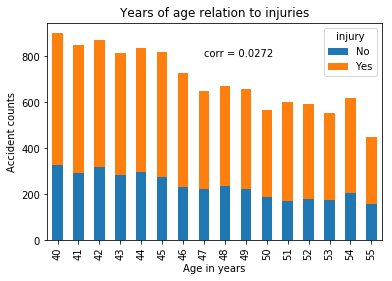

Correlation: 0.02723606699838078


In [9]:
age_injury = pd.crosstab(index=df_train["age_in_years"], 
                          columns=df_train["injury"].map(lambda x: 'Yes' if x==1 else 'No'))
age_injury.plot(kind="bar", 
                 figsize=(6,4),
                 stacked=True,
                 title='Years of age relation to injuries',
               )
plt.xlabel('Age in years')
plt.ylabel('Accident counts')
corr = df_train['age_in_years'].corr(df_train['injury'])
plt.text(7,800, 'corr = {:1.4f}'.format(corr))
plt.show()
print('Correlation: {}'.format(df_train['age_in_years'].corr(df_train['injury'])))

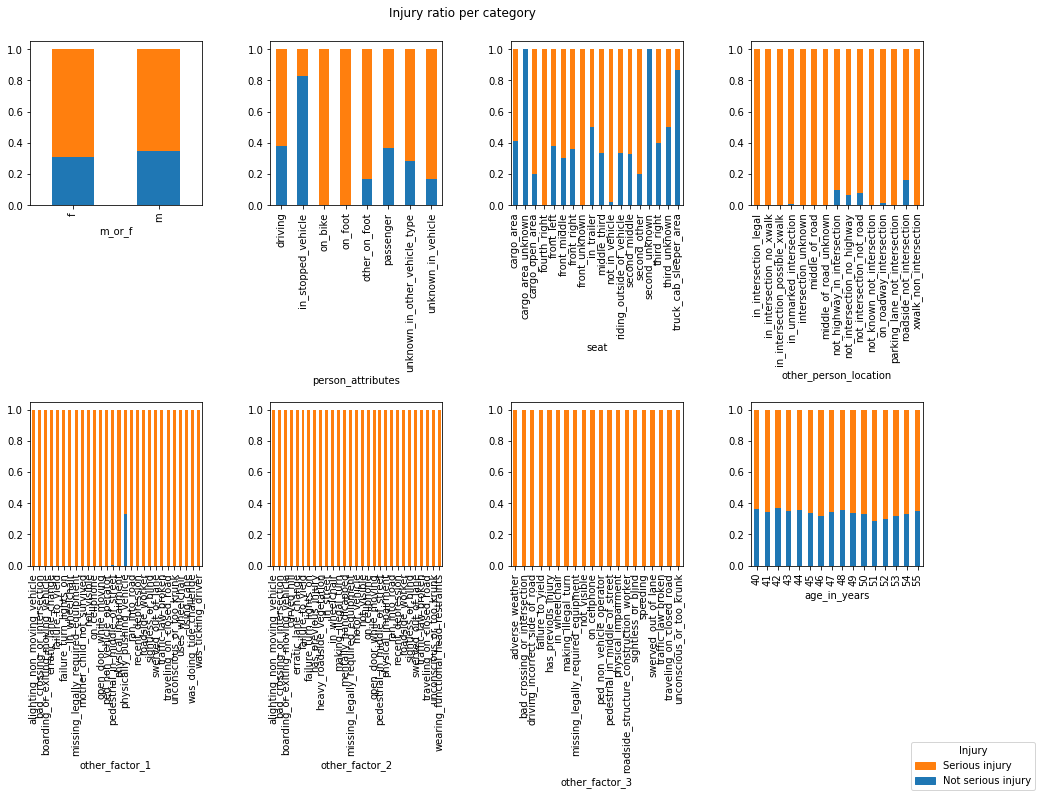

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(len(df_train.columns[:-1])):
    pd.crosstab(index=df_train.iloc[:,i], 
            columns=df_train["injury"],
            dropna=False
           ).apply(lambda x: x / x.sum(), axis=1
            ).plot(kind="bar", 
                 stacked=True, 
                 legend=None,
                 ax=axes[int(i/4), i%4]
               )
fig.legend(handles = [mpatches.Patch(color=color_cycle[1], label='Serious injury'),
                      mpatches.Patch(color=color_cycle[0], label='Not serious injury')
                     ],
           title='Injury',
           loc='lower right', 
          )
fig.suptitle('Injury ratio per category')
plt.subplots_adjust(top = 0.92, bottom=0.01, hspace=1.2, wspace=0.4)
plt.show()

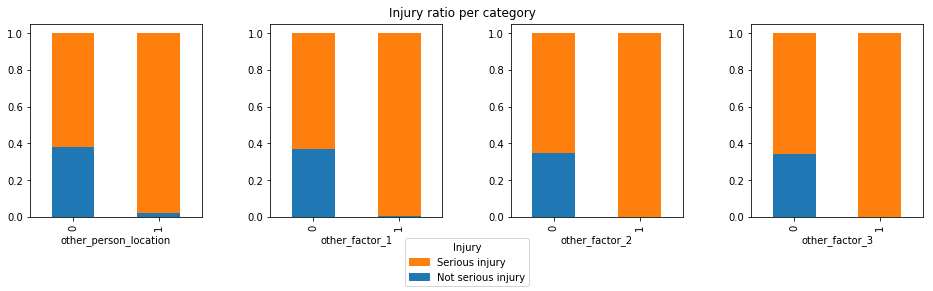

In [11]:
xy_train = make_pipeline(
        NAEncoder(['other_person_location','other_factor_1', 'other_factor_2', 'other_factor_3']),
        ColumnDropper('age_in_years'),
).fit_transform(df_train)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4), squeeze=False)
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i in range(4):
    pd.crosstab(index=xy_train.iloc[:,i+3], 
            columns=xy_train["injury"],
            dropna=False
           ).apply(lambda x: x / x.sum(), axis=1
            ).plot(kind="bar", 
                 stacked=True, 
                 legend=None,
                 ax=axes[int(i/4), i%4]
               )
fig.legend(handles = [mpatches.Patch(color=color_cycle[1], label='Serious injury'),
                      mpatches.Patch(color=color_cycle[0], label='Not serious injury')
                     ],
           title='Injury',
           loc='lower center', 
          )
fig.suptitle('Injury ratio per category')
plt.subplots_adjust(top = 0.92, bottom=0.25, hspace=1.2, wspace=0.4)
plt.show()

In [12]:
make_pipeline(
        NAEncoder(['other_person_location']),
        NAEncoder(['other_factor_1', 'other_factor_2', 'other_factor_3']),
        ColumnDropper('age_in_years'),
).fit_transform(df_train).groupby(
    ['person_attributes', 'seat', 'other_person_location', 'm_or_f',
       'other_factor_1', 'other_factor_2', 'other_factor_3']
).agg(['count', 'mean']).sort_values(by=('injury', 'count'), ascending=False)

injury  \
                                                                                                                                   count   
person_attributes             seat                      other_person_location m_or_f other_factor_1 other_factor_2 other_factor_3          
driving                       front_left                0                     m      0              0              0                6529   
                                                                              f      0              0              0                1971   
passenger                     front_right               0                     f      0              0              0                 597   
                                                                              m      0              0              0                 556   
on_foot                       not_in_vehicle            1                     m      1              0              0                 373   
                                                                                     0              0              0                 218   
                                                                                     1              1              0                 150   
                                                                              f      1              0              0                 122   
                                                                                     0              0              0                  93   
on_bike                       not_in_vehicle            1                     m      1              0              0                  69   
                                                                                     0              0              0                  65   
on_foot                       not_in_vehicle            1                     f      1              1              0                  52   
                                                                              m      1              1              1                  49   
passenger                     second_middle             0                     f      0              0              0                  22   
                              front_middle              0                     f      0              0              0                  21   
                              second_middle             0                     m      0              0              0                  21   
                              cargo_area                0                     m      0              0              0                  20   
on_bike                       not_in_vehicle            1                     m      1              1              0                  19   
passenger                     cargo_open_area           0                     m      0              0              0                  18   
on_foot                       not_in_vehicle            1                     f      1              1              1                  14   
passenger                     cargo_area                0                     f      0              0              0                  14   
                              front_middle              0                     m      0              0              0                  13   
in_stopped_vehicle            not_in_vehicle            1                     m      0              0              0                  13   
passenger                     truck_cab_sleeper_area    0                     m      0              0              0                  12   
                              riding_outside_of_vehicle 0                     m      0              0              0                  11   
on_bike                       not_in_vehicle            1                     m      1              1              1                  11   
in_stopped_vehicle            not_in_vehicle            1             